# Predicting house prices: a regression example

<div class="alert alert-block alert-info">
This Python Notebook is based on <a href=https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/3.7-predicting-house-prices.ipynb>https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/3.7-predicting-house-prices.ipynb</a>.
</div>

The aim is to build and use a simple feedforward neural network to perform "regression", that is, predict a continuous value based on some input variables. 


In [1]:
import torch
device = torch.device('cpu')
print("Device: {}".format(device))

Device: cpu


## The Boston Housing Price dataset

I will be attempting to predict the median price of homes in a given Boston suburb in the mid-1970s, given a few properties of the suburb at the time, such as the crime rate, the local property tax rate, etc. 


In [2]:
from sklearn.model_selection  import train_test_split
from sklearn.datasets import load_boston
import pandas as pd

boston = load_boston()

# Load the data to a Panda's Dataframe
boston_df = pd.DataFrame(boston['data'] )
boston_df.head()

# Add the column names.
boston_df.columns = boston['feature_names']
boston_df.head()

# Add the target as PRICE. 
boston_df['PRICE']= boston['target']
boston_df.head()

# y is the dependent variable.
y = boston_df['PRICE'].to_numpy()
#iloc is used to slice the array by index number. Here this is the matrix of 
#independent variables.
X = boston_df.iloc[:,0:13].to_numpy()

# Split the data into a training set and a test set
train_data, test_data, train_targets, test_targets = train_test_split(X, y, test_size=0.2, random_state=0)



In [3]:
#Let's check the shape of our train and test data:
print("shape of train data:",train_data.shape)
print("shape of train data:",test_data.shape)

shape of train data: (404, 13)
shape of train data: (102, 13)



We have 404 training samples and 102 test samples. The data comprises 13 features. The 13 features in the input data are as follow:

1. Per capita crime rate.
2. Proportion of residential land zoned for lots over 25,000 square feet.
3. Proportion of non-retail business acres per town.
4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5. Nitric oxides concentration (parts per 10 million).
6. Average number of rooms per dwelling.
7. Proportion of owner-occupied units built prior to 1940.
8. Weighted distances to five Boston employment centres.
9. Index of accessibility to radial highways.
10. Full-value property-tax rate per \\$10,000.
11. Pupil-teacher ratio by town.
12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
13. % lower status of the population.

The targets are the median values of owner-occupied homes, in thousands of dollars. Let's see some sample values:

In [4]:
train_targets[:10] #The prices are typically between \\$10,000 and \\$50,000. 

array([26.7, 21.7, 22. , 22.9, 10.4, 21.9, 20.6, 26.4, 41.3, 17.2])

## Preparing the data


The features composing the input data have different scales. For instance, some values are proportions, which take values between 0 and 1, others take values between 1 and 12, others between 0 and 100... It would be problematic to feed into neural network values that all take wildly different ranges. The network might automatically adapt to such heterogeneous data, but it would make learning more difficult. A widespread best practice to deal with such data is to do feature-wise standardization. For each feature in the input data (a column in the input data matrix), we will subtract the feature's mean and divide by the standard deviation. Then, the feature will be centered around 0 and will have a unit standard deviation. 
<br><br>

<center><span style="font-size: 150%">$ x_{standardized} = \frac{x - \mu}{\sigma} $</span></center>



In [5]:
# Standardization of training and testing input data

# Computing mean and standard deviation of the training data
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

# Standardizing training and test data
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std


In [6]:
#transform data to Pytorch tensors.
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_targets = torch.Tensor(train_targets)
test_targets = torch.Tensor(test_targets)

## Building the network

Because so few samples are available, we will be using a very small network with two hidden layers, each with 64 units. In general, the less training data you have, the worse overfitting will be, and using a small network is one way to mitigate overfitting.

To instantiate the model, We will use [a sequential container](https://pytorch.org/docs/master/generated/torch.nn.Sequential.html?highlight=sequential#torch.nn.Sequential), which allows to create a neural network simply by stacking layers. Given some input data, Pytorch will automatically perform the forward pass based on the network's definition. Backpropagation of the error is also handled automatically by the framework given an optimizer and a loss function.

Here, you need to create a model using a sequential container and add the three layers (two hidden layers + the output layer). We will use the ReLU activation function for the two hidden layers. 

In [7]:
from torch.nn import Sequential
from torch import nn

in_size = train_data.shape[1]

def build_model():
  
    model = Sequential()
    #Add layer 1    
    model.add_module('Linear_1', nn.Linear(in_features=in_size, out_features=64, bias=True))
    model.add_module('Relu_1', nn.ReLU())

    #Add layer 2
    model.add_module('Linear_2', nn.Linear(in_features=64, out_features=64, bias=True))
    model.add_module('Relu_2', nn.ReLU())
    #Add layer 3
    model.add_module('Linear_3', nn.Linear(in_features=64, out_features=1, bias=True))    
    
    return model


## Visualizing the network's definition

In [8]:
from torchsummary import summary

model = build_model()
model = model.to(device)
summary(model, input_size=(1, in_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]             896
              ReLU-2                [-1, 1, 64]               0
            Linear-3                [-1, 1, 64]           4,160
              ReLU-4                [-1, 1, 64]               0
            Linear-5                 [-1, 1, 1]              65
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [9]:
#For the first layer:

#Weights:
weights = model[0].weight # a Tensor
print("Shape of parameters:", weights.shape)
print("First value:", weights[0][0].item())

#Bias:
bias = model[0].bias # a Tensor
print("Shape of parameters:", bias.shape)
print("First value:", bias[0].item())

Shape of parameters: torch.Size([64, 13])
First value: -0.22670592367649078
Shape of parameters: torch.Size([64])
First value: -0.25150948762893677


## Exercise 4 - Validating our approach using K-fold validation


In [10]:
from torch import optim
import numpy as np
from random import shuffle

k = 4 #number of crossvalidation folds
batch_size = 1
num_val_samples = len(train_data) // k
num_epochs = 100

all_scores = [] # Should add the score of each run at the end of the loop

for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = torch.cat(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = torch.cat(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    # Build the model
    model = build_model()
    # Define an SGD optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.001) 
    # Define the MAE loss function 
    mae_loss = nn.L1Loss(reduction='mean')
    # Defina the MSE loss function
    mse_loss = nn.MSELoss(reduction='mean')
    
    # TRAIN THE MODEL:
    # Set the model to train
    model.train()
    # Create some random indices to go through the dataset randomly
    batch_indeces = list(range(len(partial_train_data)//batch_size))
    shuffle(batch_indeces)

    # Train cycle:
    for epoch in range(num_epochs):
        for b_idx in batch_indeces:

            # Set gradients to zero for all parameters
            optimizer.zero_grad()

            # Create the batch
            batch_start = b_idx * batch_size
            batch_end = (b_idx + 1) * batch_size            
            data_batch = partial_train_data[batch_start : batch_end]
            target_batch = partial_train_targets[batch_start : batch_end].squeeze()

            # Get the predictions from the model
            predictions = model(data_batch).squeeze()

            # Calcualte the loss function
            loss = mse_loss(predictions, target_batch)

            # Back propagate and update parameters
            loss.backward()
            optimizer.step()
        
    # Evaluate the model on the validation data
    model.eval()
    predictions = model(val_data).squeeze()
    val_mae = mae_loss(predictions, val_targets)
    val_mse = mse_loss(predictions, val_targets)
    all_scores.append(val_mae.item())


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [11]:
np.mean(all_scores)

2.7599481344223022

Let's try training the network for a bit longer: 250 epochs. To keep a record of how well the model did at each epoch, we will modify our training loop 
to save the per-epoch training and validation score log:

In [12]:

k = 4
batch_size = 4
num_val_samples = len(train_data) // k
num_epochs = 250
all_mae_histories = []
val_all_mae_histories = []

for i in range(k):
    train_history = []
    val_history = []

    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = torch.cat(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = torch.cat(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    # Build the model
    model = build_model()
    # Define an SGD optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.001) 
    # Define the MAE loss function 
    mae_loss = nn.L1Loss(reduction='mean')
    # Defina the MSE loss function
    mse_loss = nn.MSELoss(reduction='mean')
    
    # TRAIN THE MODEL:
    # Set the model to train
    model.train()
    # Create some random indices to go through the dataset randomly
    batch_indeces = list(range(len(partial_train_data)//batch_size))
    shuffle(batch_indeces)

    # Train cycle:
    for epoch in range(num_epochs):
        running_train_loss=0
        for b_idx in batch_indeces:

            # Set gradients to zero for all parameters
            optimizer.zero_grad()

            # Create the batch
            batch_start = b_idx * batch_size
            batch_end = (b_idx + 1) * batch_size            
            data_batch = partial_train_data[batch_start : batch_end]
            target_batch = partial_train_targets[batch_start : batch_end]

            # Get the predictions from the model
            predictions = model(data_batch).squeeze()

            # Calcualte the loss function
            loss = mse_loss(predictions, target_batch)

            # Back propagate and update parameters
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        train_mae = running_train_loss / len(batch_indeces)
        train_history.append(train_mae)
        
        # Evaluate the model on the validation data
        
        model.eval()
        predictions = model(val_data).squeeze()
        val_mae = mae_loss(predictions, val_targets).item()
        val_history.append(val_mae)
        
    
    all_mae_histories.append(train_history)
    val_all_mae_histories.append(val_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [13]:
# We can then compute the average of the per-epoch MAE scores for all folds:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
val_average_mae_history = [
    np.mean([x[i] for x in val_all_mae_histories]) for i in range(num_epochs)]

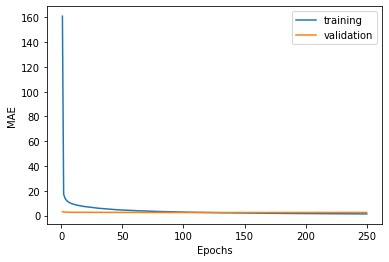

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.plot(range(1, len(val_average_mae_history) + 1), val_average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(['training', 'validation'])
plt.show()

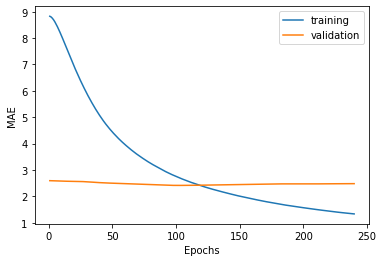

In [15]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])
val_smooth_mae_history = smooth_curve(val_average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.plot(range(1, len(val_smooth_mae_history) + 1), val_smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(['training', 'validation'])
plt.show()

In [16]:
import numpy as np
from random import shuffle
num_epochs = 60

# Build the model
train_history = []
val_history = []
model = build_model()
optimizer = optim.SGD(model.parameters(), lr=0.001)
mae_loss = nn.L1Loss(reduction='mean')
mse_loss = nn.MSELoss(reduction='mean')
# Train the model
model.train()
batch_indeces = list(range(len(train_data)//batch_size))
shuffle(batch_indeces)
for epoch in range(num_epochs):
    for b_idx in batch_indeces:
        optimizer.zero_grad()
        batch_start = b_idx * batch_size
        batch_end = (b_idx + 1) * batch_size
        data_batch = train_data[batch_start : batch_end]
        targets_batch = train_targets[batch_start : batch_end]
        
        predictions = model(data_batch).squeeze()
        loss = mse_loss(predictions, targets_batch)
        
        loss.backward()
        optimizer.step()
    
model.eval()
predictions = model(test_data).squeeze()
test_mae_score = mae_loss(predictions, test_targets)


In [17]:
test_mae_score # We are still off by about:$3.000

tensor(2.9924, grad_fn=<L1LossBackward>)